In [1]:
from dotenv import load_dotenv
import pandas as pd


import sys
import os
sys.path.append(os.path.abspath('../')) 
from Preprocessing.preprocessing_pipeline_impute_fuel_types_no_drop import preprocessing_pipeline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

import concurrent.futures
import functools


# LangChain-spezifische Imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()  # lädt .env automatisch
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")



In [2]:
segments = [
    "Kleinwagen", "Kompaktklasse", "Mittelklasse", "Obere Mittelklasse",
    "Luxusklasse", "SUV", "Van", "Sportwagen", "Supersportwagen"
]

new_system_prompt = f'''Du bist ein Experte für Automobilklassifikation in Deutschland. Deine Aufgabe ist es, Automodelle (inkl. Marke) einem der folgenden {len(segments)} vordefinierten Fahrzeugsegmenten zuzuordnen.
Bitte gib nur den Namen des passenden Segments zurück. Stelle sicher, dass deine Antwort EXAKT einem der unten genannten Segmente entspricht.

Die Segmente und Beispiele sind:

1.  Kleinwagen: Kleine Stadtflitzer und Superminis.
     z.B.: VW Polo, Opel Corsa, Ford Fiesta, Renault Clio, Peugeot 208, Toyota Yaris, Skoda Fabia, Fiat 500, Mini Cooper, Hyundai i20, Seat Ibiza

2.  Kompaktklasse: Die "Golf-Klasse", untere Mittelklasse.
     z.B.: VW Golf, Audi A3, BMW 1er, Mercedes A-Klasse, Opel Astra, Ford Focus, Seat Leon, Skoda Octavia, Hyundai i30, Kia Ceed

3.  Mittelklasse: Standard-Limousinen und Kombis für Familie/Beruf.
     z.B.: VW Passat, Audi A4, BMW 3er, Mercedes C-Klasse, Skoda Superb, Ford Mondeo, Opel Insignia, Volvo S60/V60, Tesla Model 3

4.  Obere Mittelklasse: Größere Geschäfts- und Reisefahrzeuge.
     z.B.: Audi A6, BMW 5er, Mercedes E-Klasse, Volvo S90/V90, Jaguar XF, Lexus ES

5.  Luxusklasse: Repräsentative Luxusfahrzeuge.
     z.B.: Audi A8, BMW 7er, Mercedes S-Klasse, Porsche Panamera, Lexus LS, Bentley Continental GT, Tesla Model S

6.  SUV: Sport Utility Vehicles, verschiedene Größen, oft mit erhöhter Sitzposition.
    z.B.: VW Tiguan, VW Touareg, Audi Q3/Q5/Q7, BMW X1/X3/X5, Mercedes GLA/GLC/GLE, Ford Kuga, Skoda Kodiaq/Karoq, Porsche Macan/Cayenne, Volvo XC60, Dacia Duster

7.  Van: Familienvans, Kleinbusse mit viel Platz.
     z.B.: VW Touran, VW Sharan, VW Multivan/Caravelle, Mercedes V-Klasse/Vito Tourer, Ford Galaxy/S-Max, Opel Zafira, Seat Alhambra, Renault Espace

8.  Sportwagen: Leistungsstarke Coupés, Roadster oder Sportlimousinen.
     z.B.: Porsche 911, Porsche 718 Cayman/Boxster, Audi R8, Audi TT, BMW M2/M3/M4, Mercedes-AMG GT/SL, Ford Mustang, Jaguar F-Type, Nissan GT-R, Mercedes-Benz C 43 AMG, Audi RS4

9.  Supersportwagen: Extremschnelle, sportliche Fahrzeuge.
    z.B. Aston Martin Vantage, Ferrari F12, Lamborghini Aventador

Gib mir als Output NUR das EINE passende Fahrzeugsegment aus der Liste {segments} zurück. KEINEN zusätzlichen Text.
'''  

def setup_llm_chain_with_parser():
    """Initialisiert LLM, Prompt und Chain"""
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-001", #eventuell anderes modell mal testen?
        temperature=0,
        max_tokens=50,
        timeout=None,
        max_retries=2
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", new_system_prompt),
            ("human", "{input}"),
        ]
    )
    output_parser = StrOutputParser()

    chain = prompt | llm | output_parser
    return chain


def get_llm_segment(model_input_string, chain_instance):
    """
    Ruft die LLM-Chain (mit StrOutputParser) für einen einzelnen Modell-String auf.
    Gibt den String-Output des LLM direkt zurück (ohne Validierung).

    Args:
        model_input_string: Der Input für das LLM (Format "Marke Modell").
        chain_instance: Die vorkonfigurierte LangChain-Chain (inkl. Parser).

    Returns:
        Die String-Antwort des LLM oder eine Fehlermeldung bei API-Fehler.
    """
    try:
        segment_output = chain_instance.invoke({"input": model_input_string}) # rufe llm mit der chain und dem model als input auf, speicher output
        return segment_output.strip()

    except Exception as e:
        print(f"Error calling LLM for '{model_input_string}': {e}")
        return f"Error: API Call Failed - {e}"

def run_llm_classification_parallel(model_strings_list, chain_to_use, max_workers=5):
    """
    Nutzt ThreadPoolExecutor, um get_llm_segment parallel aufzurufen.

    Args:
        model_strings_list: Liste von Strings (Format "Marke Modell").
        chain_to_use: Die vorkonfigurierte LangChain-Chain (inkl. Parser).
        max_workers: Maximale Anzahl paralleler Threads.

    Returns:
        Ein Dictionary, das Input-Strings auf Ergebnisse (LLM-Output-String oder Fehler) abbildet.
    """
    results = {}
    # functools.partial bindet die chain_to_use an die neue Funktion get_llm_segment
    func_to_call = functools.partial(get_llm_segment, chain_instance=chain_to_use)

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {executor.submit(func_to_call, model_str): model_str for model_str in model_strings_list}

        for future in concurrent.futures.as_completed(future_to_model):
            model_str = future_to_model[future]
            try:
                result_segment = future.result()
                results[model_str] = result_segment
            except Exception as exc:
                print(f'Model {model_str} generated an exception during result retrieval: {exc}')
                results[model_str] = f"Error: Exception - {exc}"
    return results

In [3]:
df = pd.read_csv('../data.csv')

yearsToFilter = list(df['year'].unique()[:29])  # wegen Scraping Fehler
filt = [val in yearsToFilter for val in df['year']]
df = df[filt]

In [4]:
df = preprocessing_pipeline(df)

In [5]:
unique_model_brand_strings = list(df[['brand', 'model']].astype(str).apply(lambda x: f"{x['brand']} {x['model']}", axis=1).unique())


print("Setting up LLM chain with parser...")
my_llm_chain_with_parser = setup_llm_chain_with_parser()
print("LLM chain ready.")

print(f"Starting parallel classification for {len(unique_model_brand_strings)} unique models...")
classification_results = run_llm_classification_parallel(
    model_strings_list=unique_model_brand_strings,
    chain_to_use=my_llm_chain_with_parser,
    max_workers=10 # bei schlechter Laufzeit anpassen
)
print("Parallel classification finished.")
    
df['segment'] = df.apply(lambda x: classification_results.get(f"{x['brand']} {x['model']}", "Error: Mapping Failed"), axis=1)

Setting up LLM chain with parser...
LLM chain ready.
Starting parallel classification for 1312 unique models...
Parallel classification finished.


In [6]:
df['segment'].value_counts()

segment
SUV                   67111
Kompaktklasse         52306
Kleinwagen            47595
Mittelklasse          28806
Van                   25971
Obere Mittelklasse    13161
Sportwagen            11739
Luxusklasse            3406
Supersportwagen         785
Name: count, dtype: int64

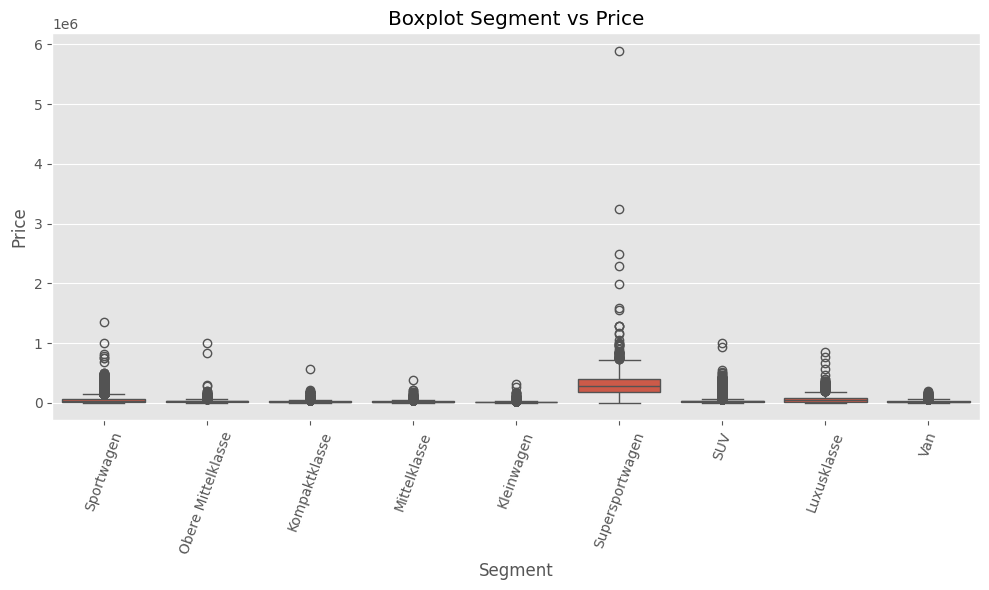

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='segment', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Segment")
plt.xticks(rotation = 70)
plt.ylabel("Price")
plt.tight_layout()
plt.show()

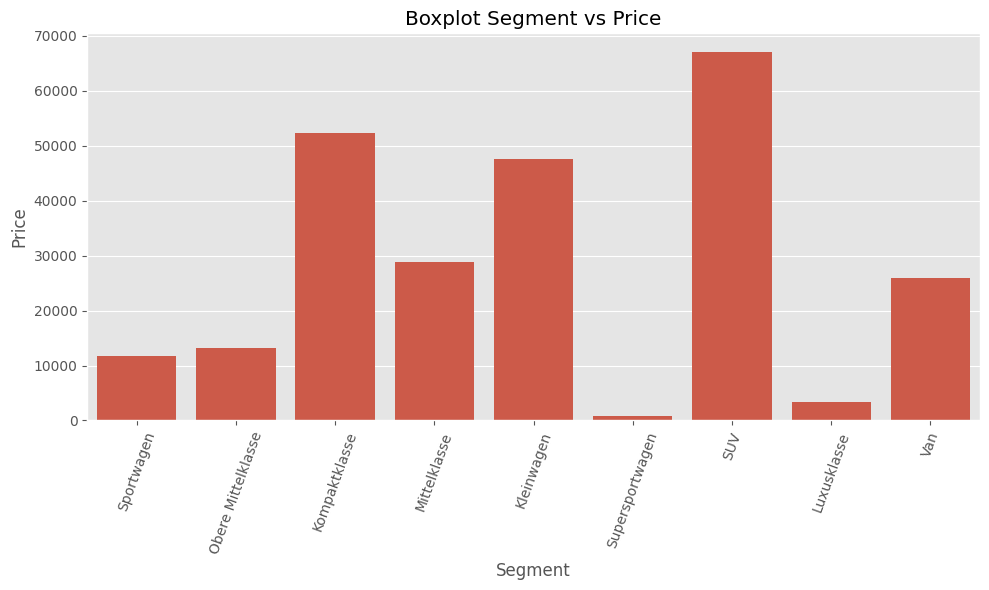

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='segment')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Segment")
plt.xticks(rotation = 70)
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [9]:
df[['brand', 'model', 'segment']]

,brand,model,segment
0,alfa-romeo,Alfa Romeo GTV,Sportwagen
1,alfa-romeo,Alfa Romeo 164,Obere Mittelklasse
2,alfa-romeo,Alfa Romeo Spider,Sportwagen
3,alfa-romeo,Alfa Romeo Spider,Sportwagen
4,alfa-romeo,Alfa Romeo 164,Obere Mittelklasse
...,...,...,...
250875,volvo,Volvo XC40,SUV
250876,volvo,Volvo XC90,SUV
250877,volvo,Volvo V60,Mittelklasse
250878,volvo,Volvo XC40,SUV


In [10]:
df.groupby(['brand', 'model'])['segment'].nunique().sort_values(ascending=False)

brand          model                 
alfa-romeo     Alfa Romeo                1
mini           MINI                      1
mercedes-benz  Mercedes-Benz X 250       1
               Mercedes-Benz X 220       1
               Mercedes-Benz Vito        1
                                        ..
hyundai        Hyundai H 350             1
               Hyundai Grand Santa Fe    1
               Hyundai Getz              1
               Hyundai Genesis Coupe     1
volvo          Volvo XC90                1
Name: segment, Length: 1312, dtype: int64

In [11]:
df_export = df[['brand', 'model', 'segment']]
df_export = df_export.drop_duplicates()

In [12]:
df_export.to_csv('df_mit_segment.csv', index= False)